In [1]:
#importing all important lib

import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)



In [2]:
df = pd.read_csv(
  "london_merged.csv",
  parse_dates=['timestamp'],
  index_col="timestamp"
)

In [3]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


## timestamp — timestamp field for grouping the data
## cnt — the count of a new bike shares
## t1 — real temperature in C
## t2 — temperature in C “feels like”
## hum — humidity in percentage
## wind_speed — wind speed in km/h
## weather_code — category of the weather
## is_holiday — boolean field — 1 holiday / 0 non holiday
## is_weekend — boolean field — 1 if the day is weekend
## season — category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.

In [4]:
df['hour'] = df.index.hour #The hours of the datetime.
df['day_of_month'] = df.index.day #The month of the datetime.
df['day_of_week'] = df.index.dayofweek #The day of week of the datetime.
df['month'] = df.index.month #The month of the datetime.

<AxesSubplot:xlabel='timestamp', ylabel='cnt'>

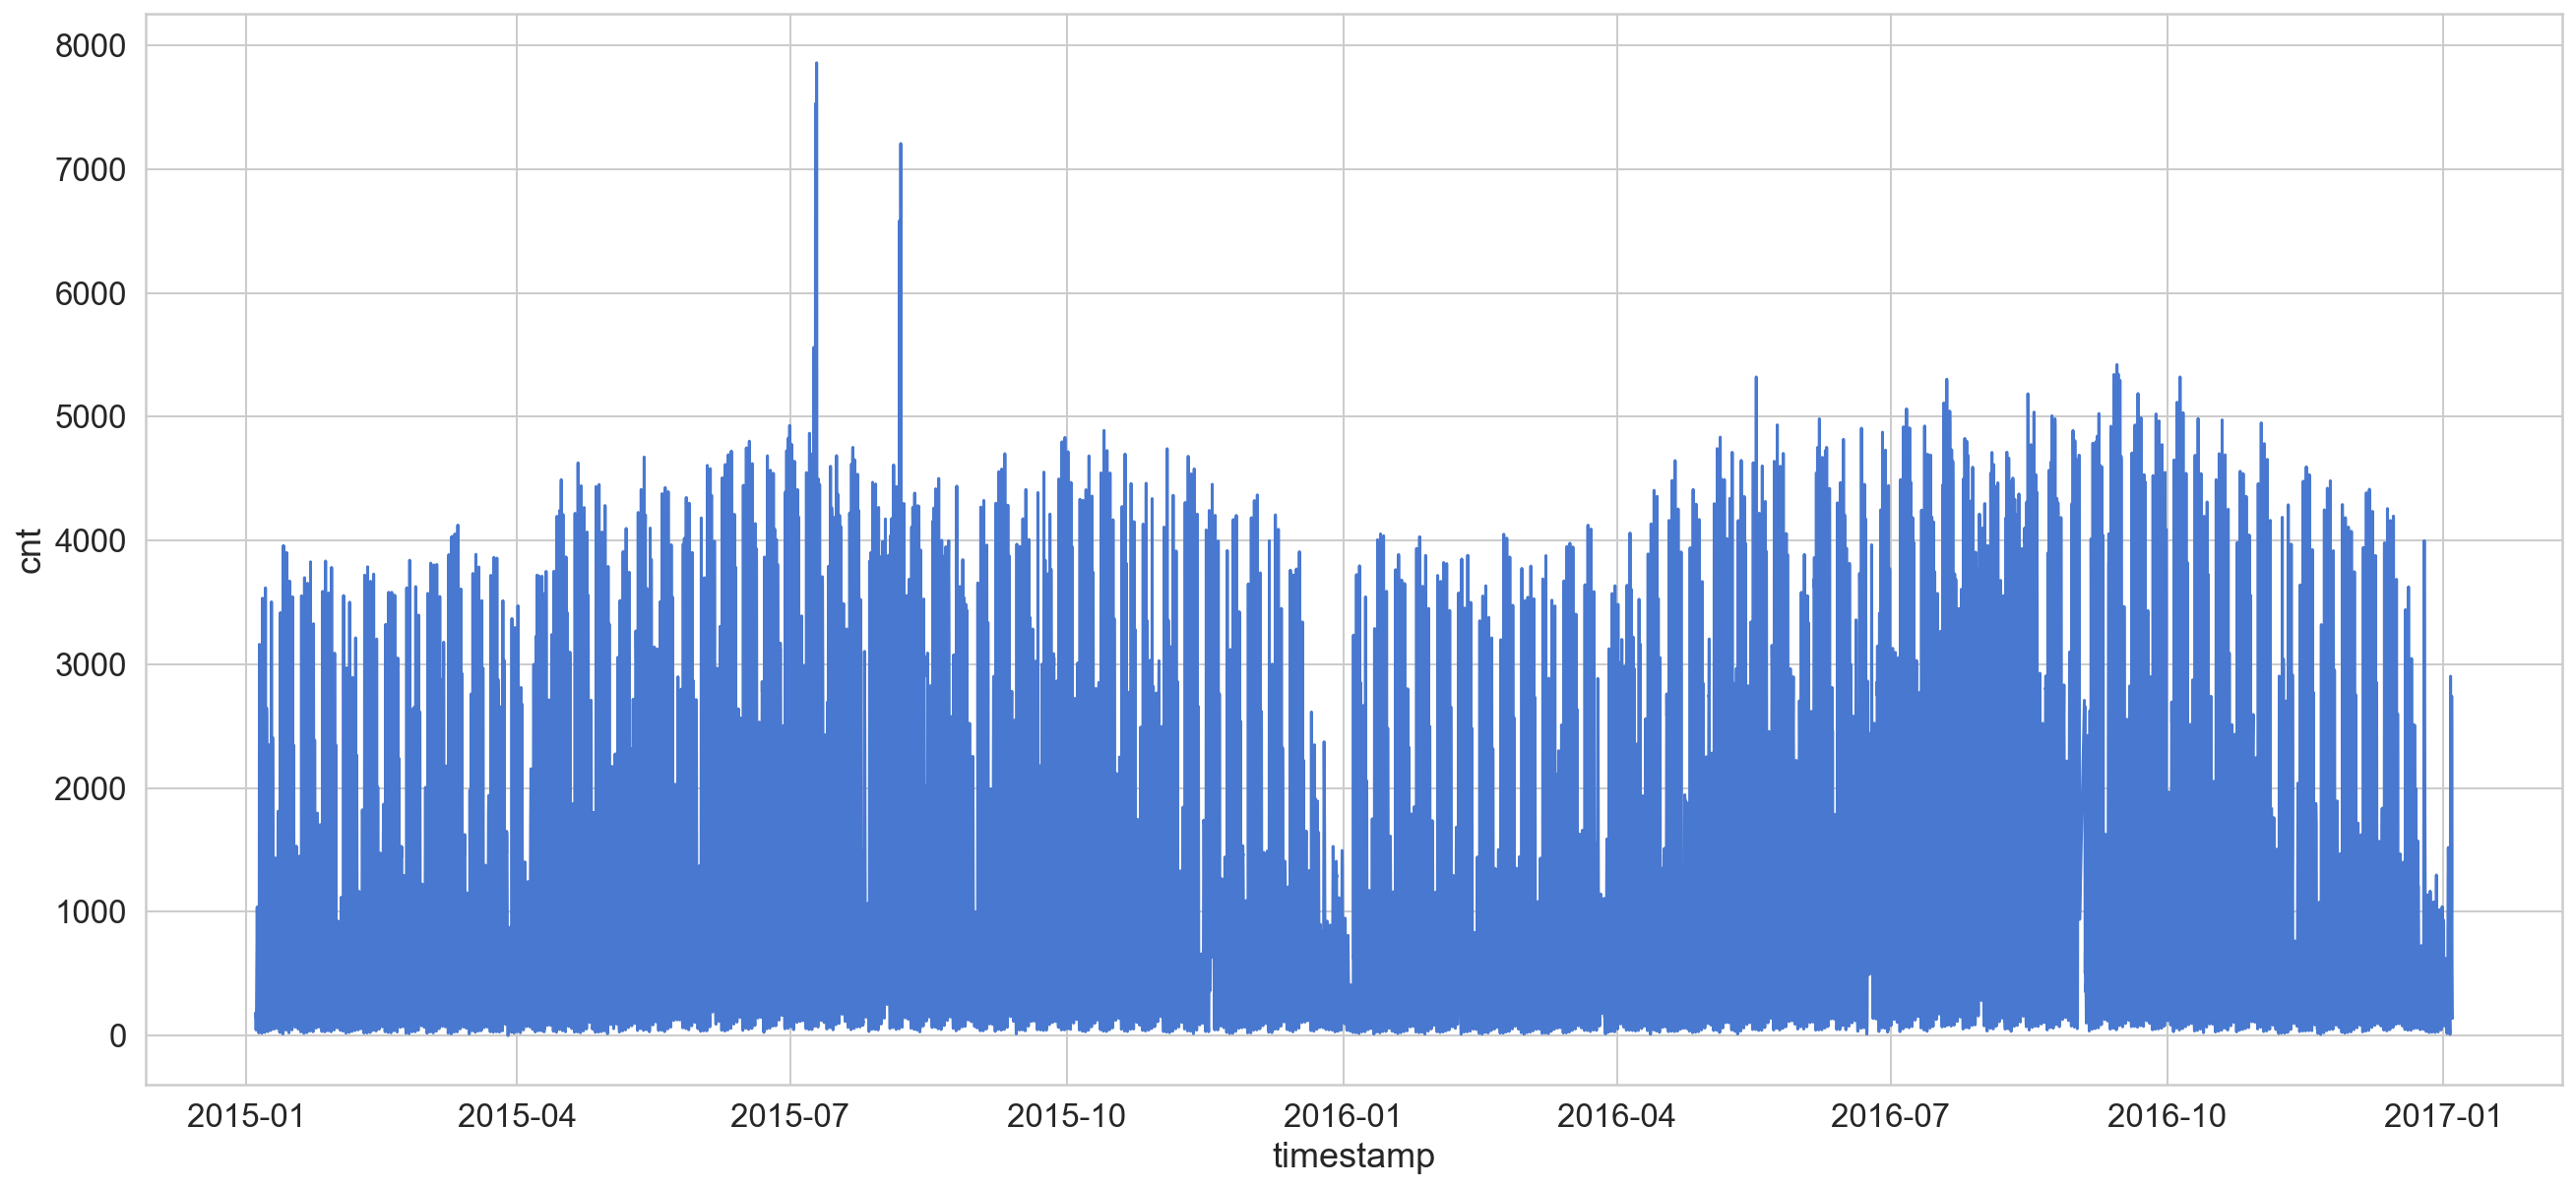

In [5]:
sns.lineplot(x=df.index, y="cnt", data=df)

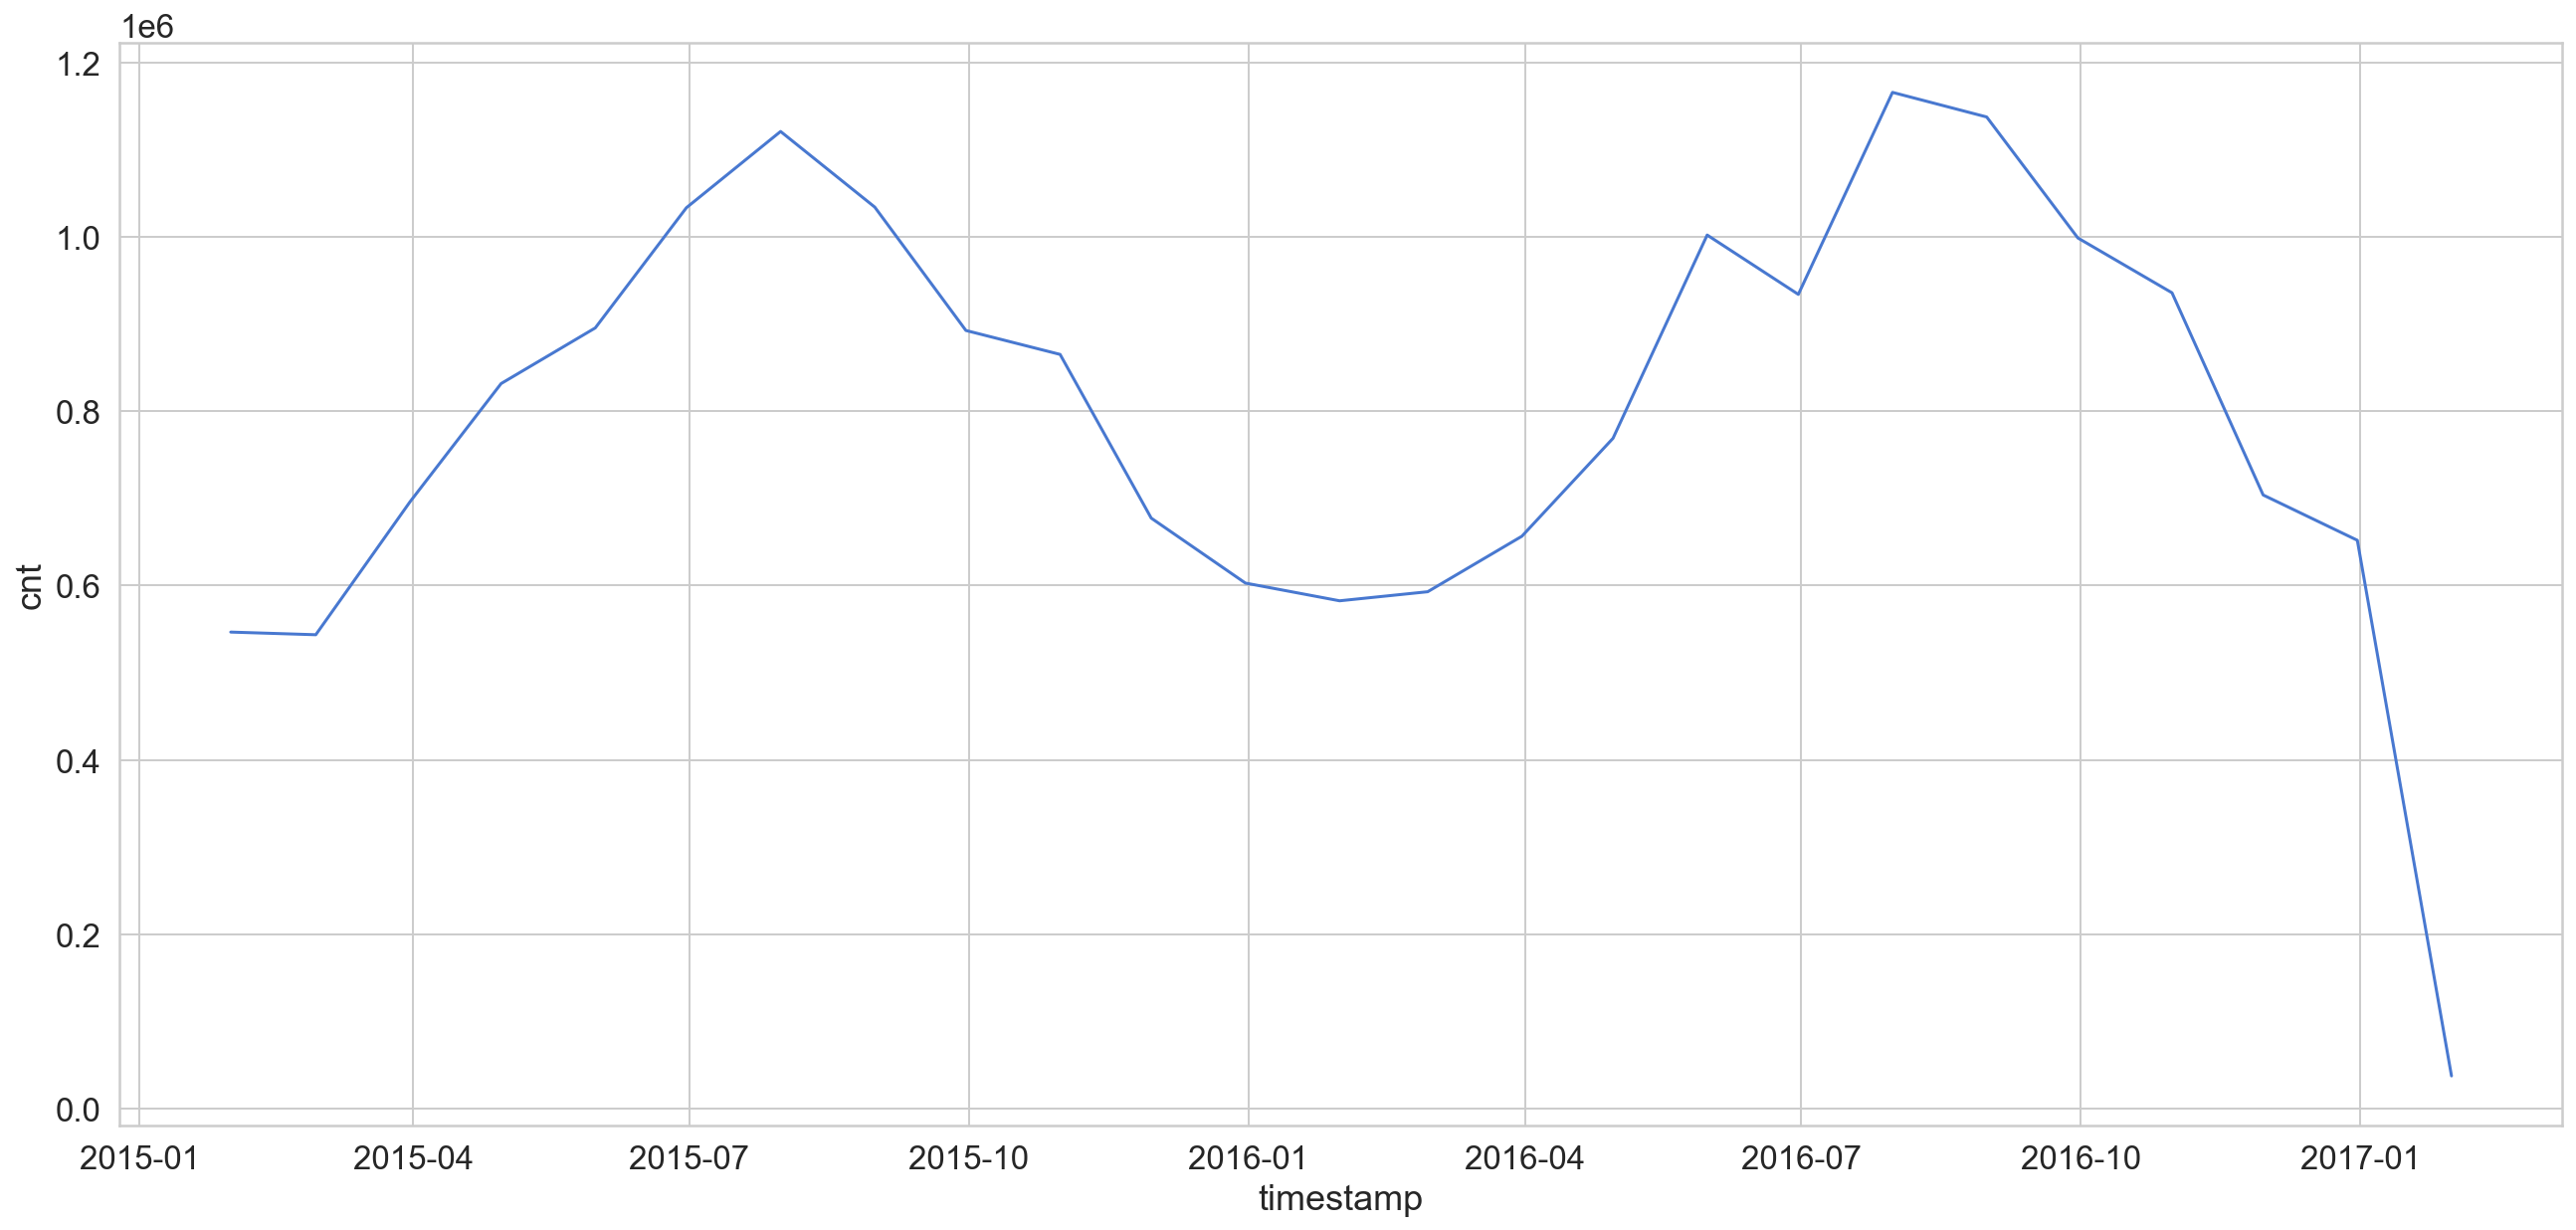

In [6]:
#Convenience method for frequency conversion and resampling of time series.
df_by_month = df.resample('M').sum()

sns.lineplot(x=df_by_month.index, y="cnt", data=df_by_month);

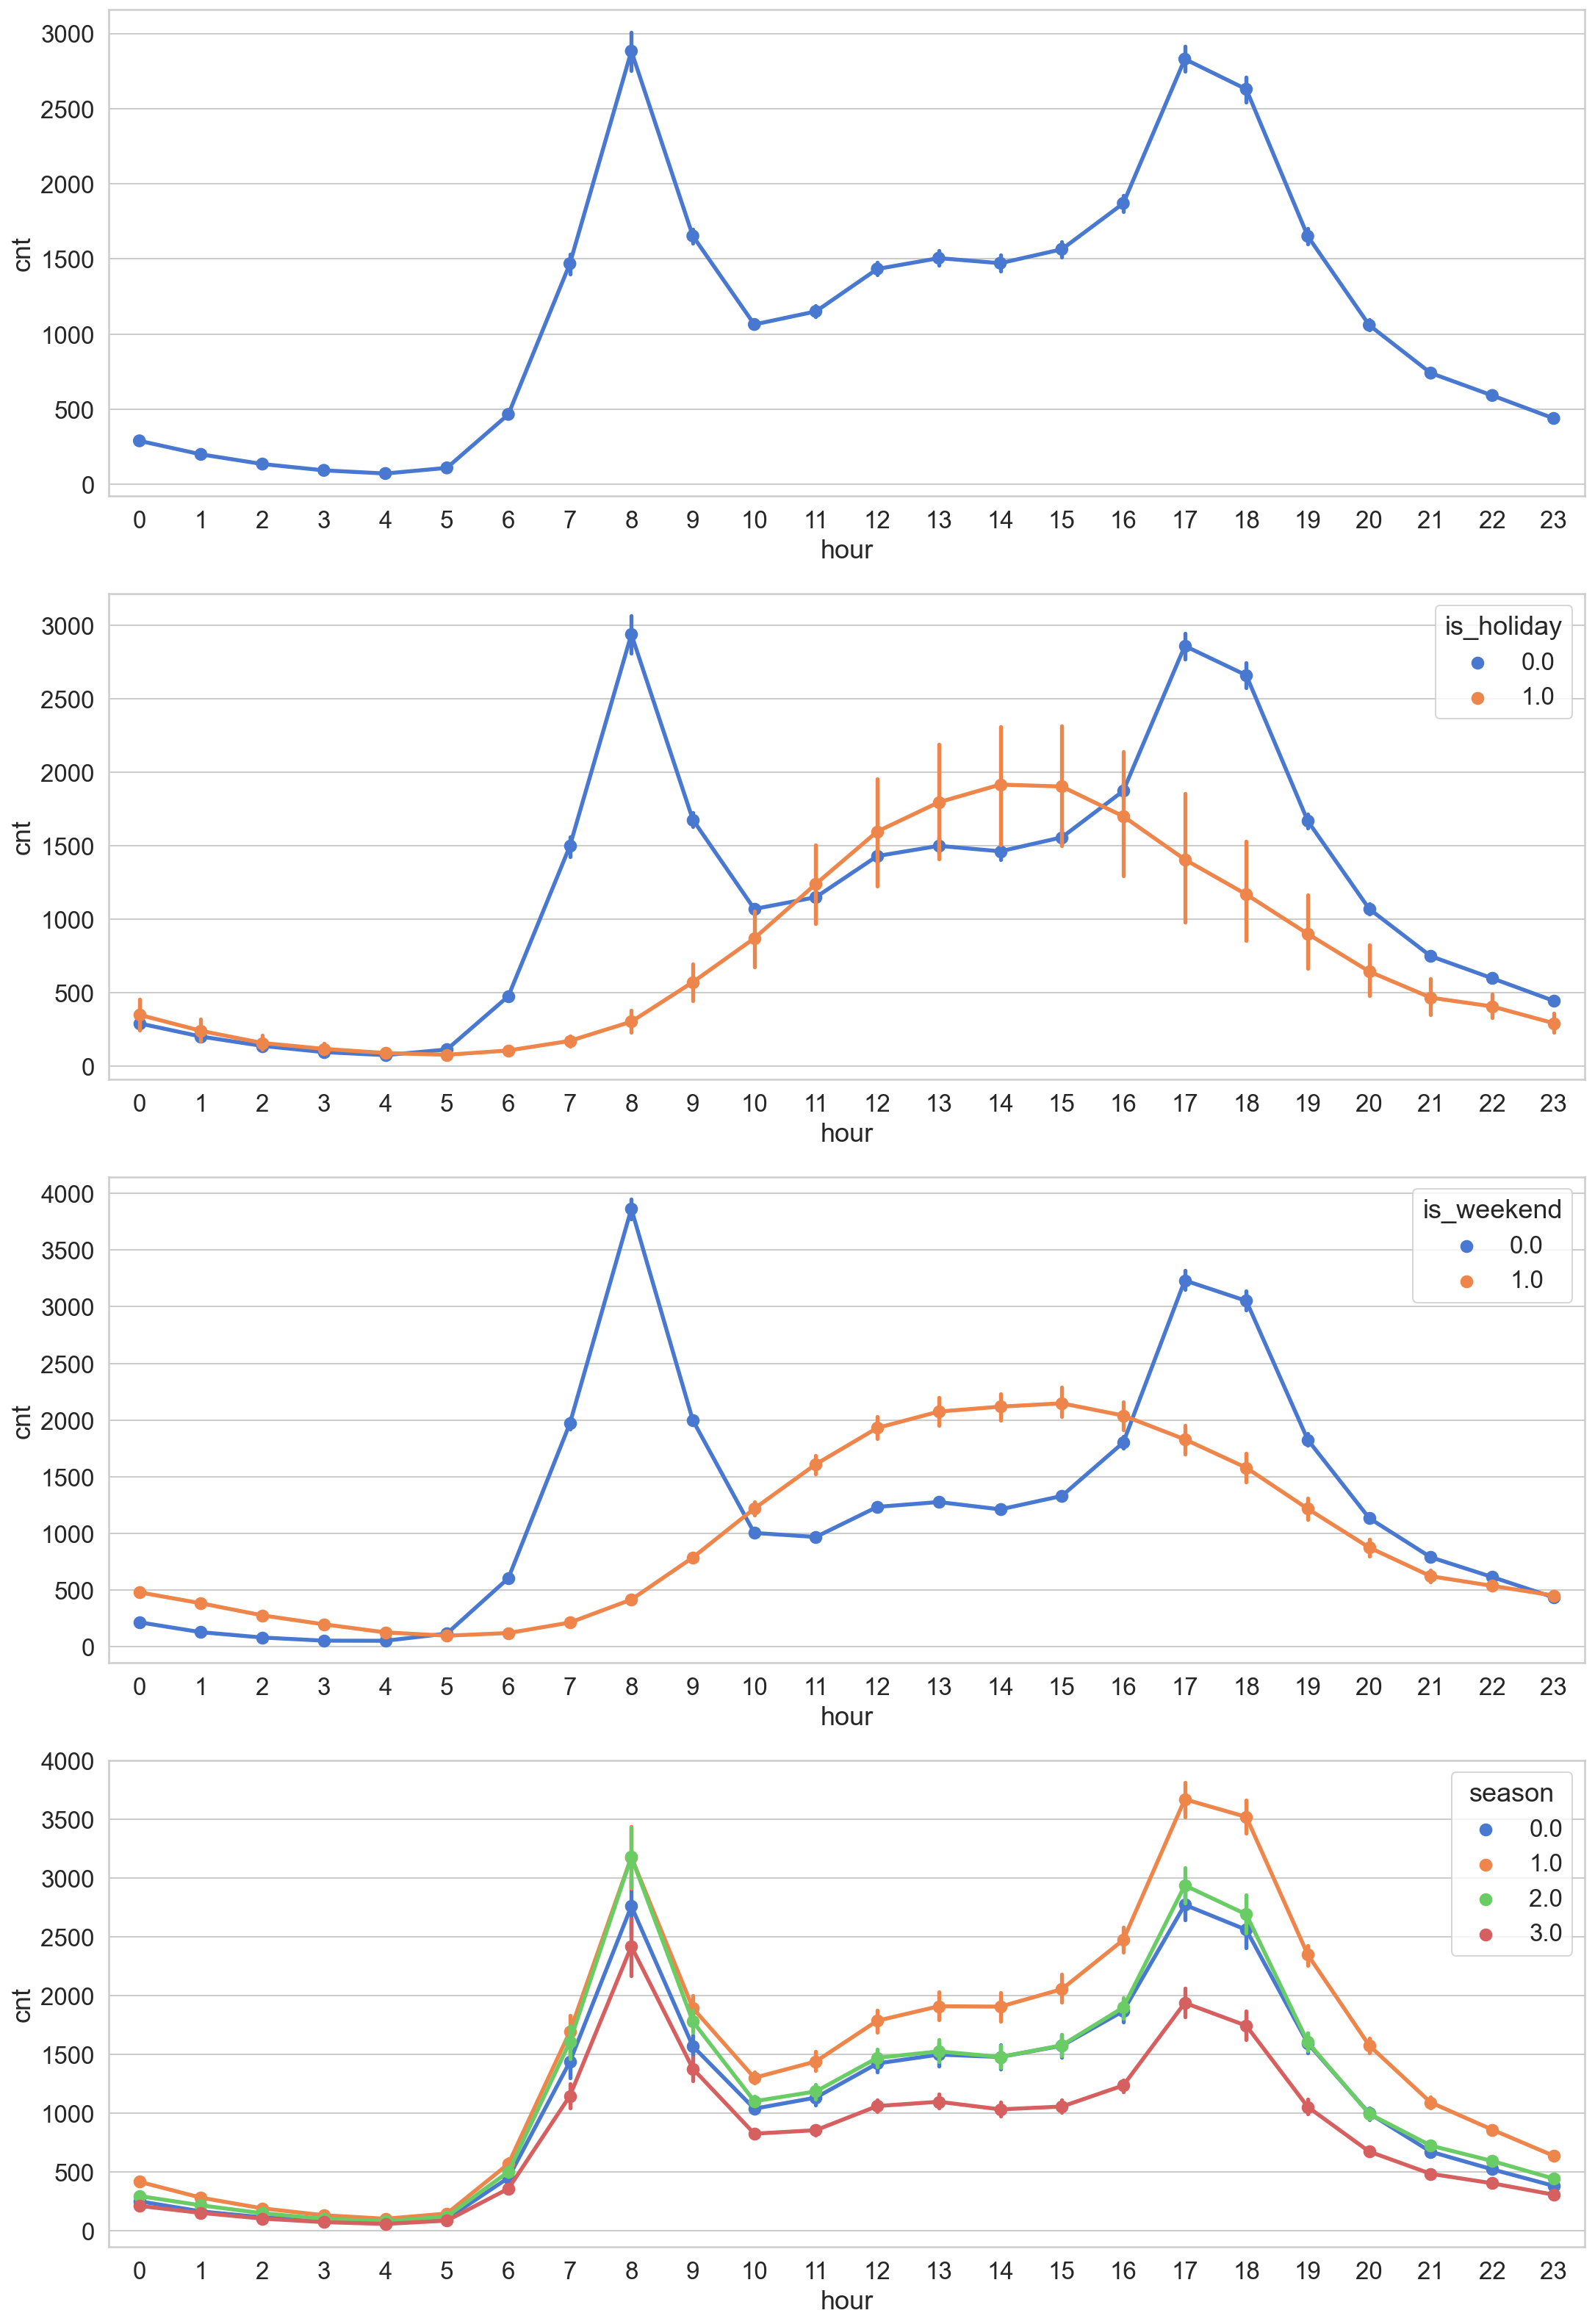

In [7]:
fig,(ax1, ax2, ax3, ax4)= plt.subplots(nrows=4)
fig.set_size_inches(18, 28)

sns.pointplot(data=df, x='hour', y='cnt', ax=ax1)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_holiday', ax=ax2)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_weekend', ax=ax3)
sns.pointplot(data=df, x='hour', y='cnt', hue='season', ax=ax4);

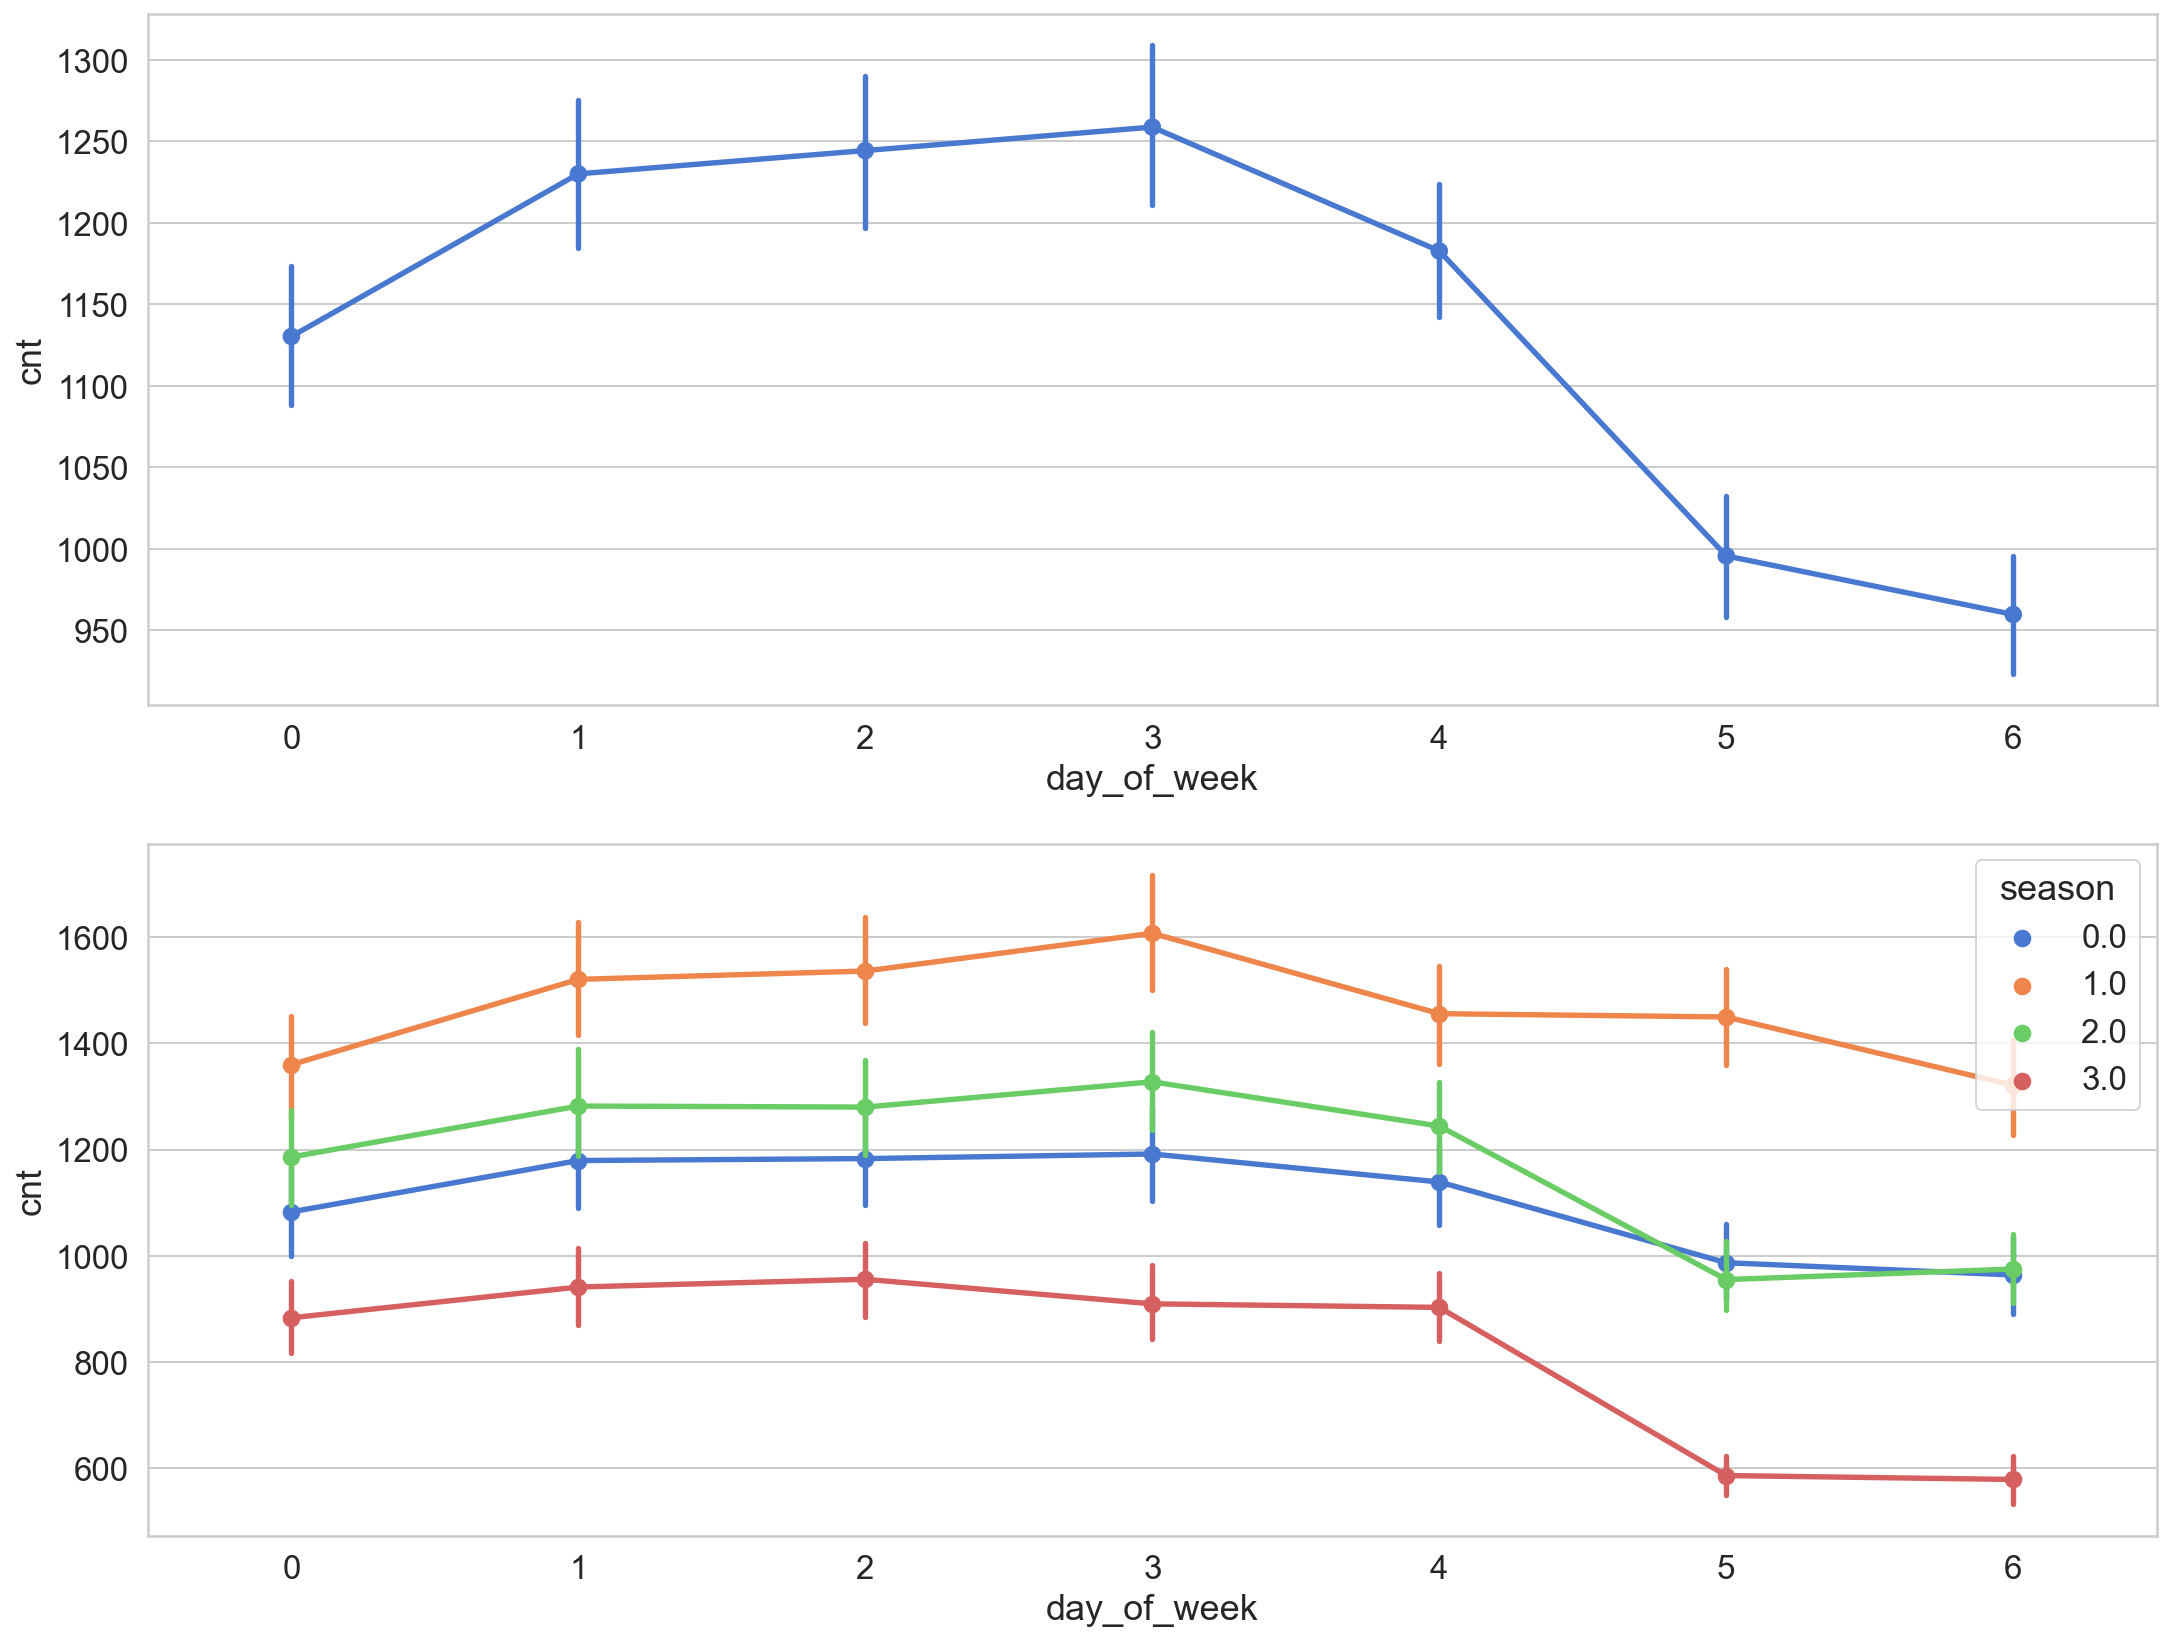

In [8]:
fig,(ax1, ax2)= plt.subplots(nrows=2)
fig.set_size_inches(18, 14)

sns.pointplot(data=df, x='day_of_week', y='cnt', ax=ax1)
sns.pointplot(data=df, x='day_of_week', y='cnt', hue='season', ax=ax2);

In [9]:
# dividing data for train and test
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

15672 1742


In [10]:
from sklearn.preprocessing import RobustScaler

f_columns = ['t1', 't2', 'hum', 'wind_speed']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['cnt']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['cnt'] = cnt_transformer.transform(train[['cnt']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['cnt'] = cnt_transformer.transform(test[['cnt']])

C:\Users\Anjil Adhikari\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
<ipython-input-10-92b06493bae2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['cnt'] = cnt_transformer.transform(train[['cnt']])
C:\Users\Anjil Adhikari\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [ ]:
To prepare the sequences,  reuse the same create_dataset() function:

In [11]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [12]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

print(X_train.shape, y_train.shape)

(15662, 10, 13) (15662,)


In [13]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [14]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
441/441 [==============================] - 42s 21ms/step - loss: 0.3270 - val_loss: 0.1255
Epoch 2/30
441/441 [==============================] - 8s 17ms/step - loss: 0.0818 - val_loss: 0.0661
Epoch 3/30
441/441 [==============================] - 8s 17ms/step - loss: 0.0512 - val_loss: 0.0552
Epoch 4/30
441/441 [==============================] - 7s 17ms/step - loss: 0.0389 - val_loss: 0.0355
Epoch 5/30
441/441 [==============================] - 8s 17ms/step - loss: 0.0306 - val_loss: 0.0309
Epoch 6/30
441/441 [==============================] - 8s 17ms/step - loss: 0.0277 - val_loss: 0.0306
Epoch 7/30
441/441 [==============================] - 8s 17ms/step - loss: 0.0270 - val_loss: 0.0319
Epoch 8/30
441/441 [==============================] - 9s 20ms/step - loss: 0.0239 - val_loss: 0.0315
Epoch 9/30
441/441 [==============================] - 8s 18ms/step - loss: 0.0235 - val_loss: 0.0320
Epoch 10/30
441/441 [==============================] - 7s 17ms/step - loss: 0.0217 - val_l

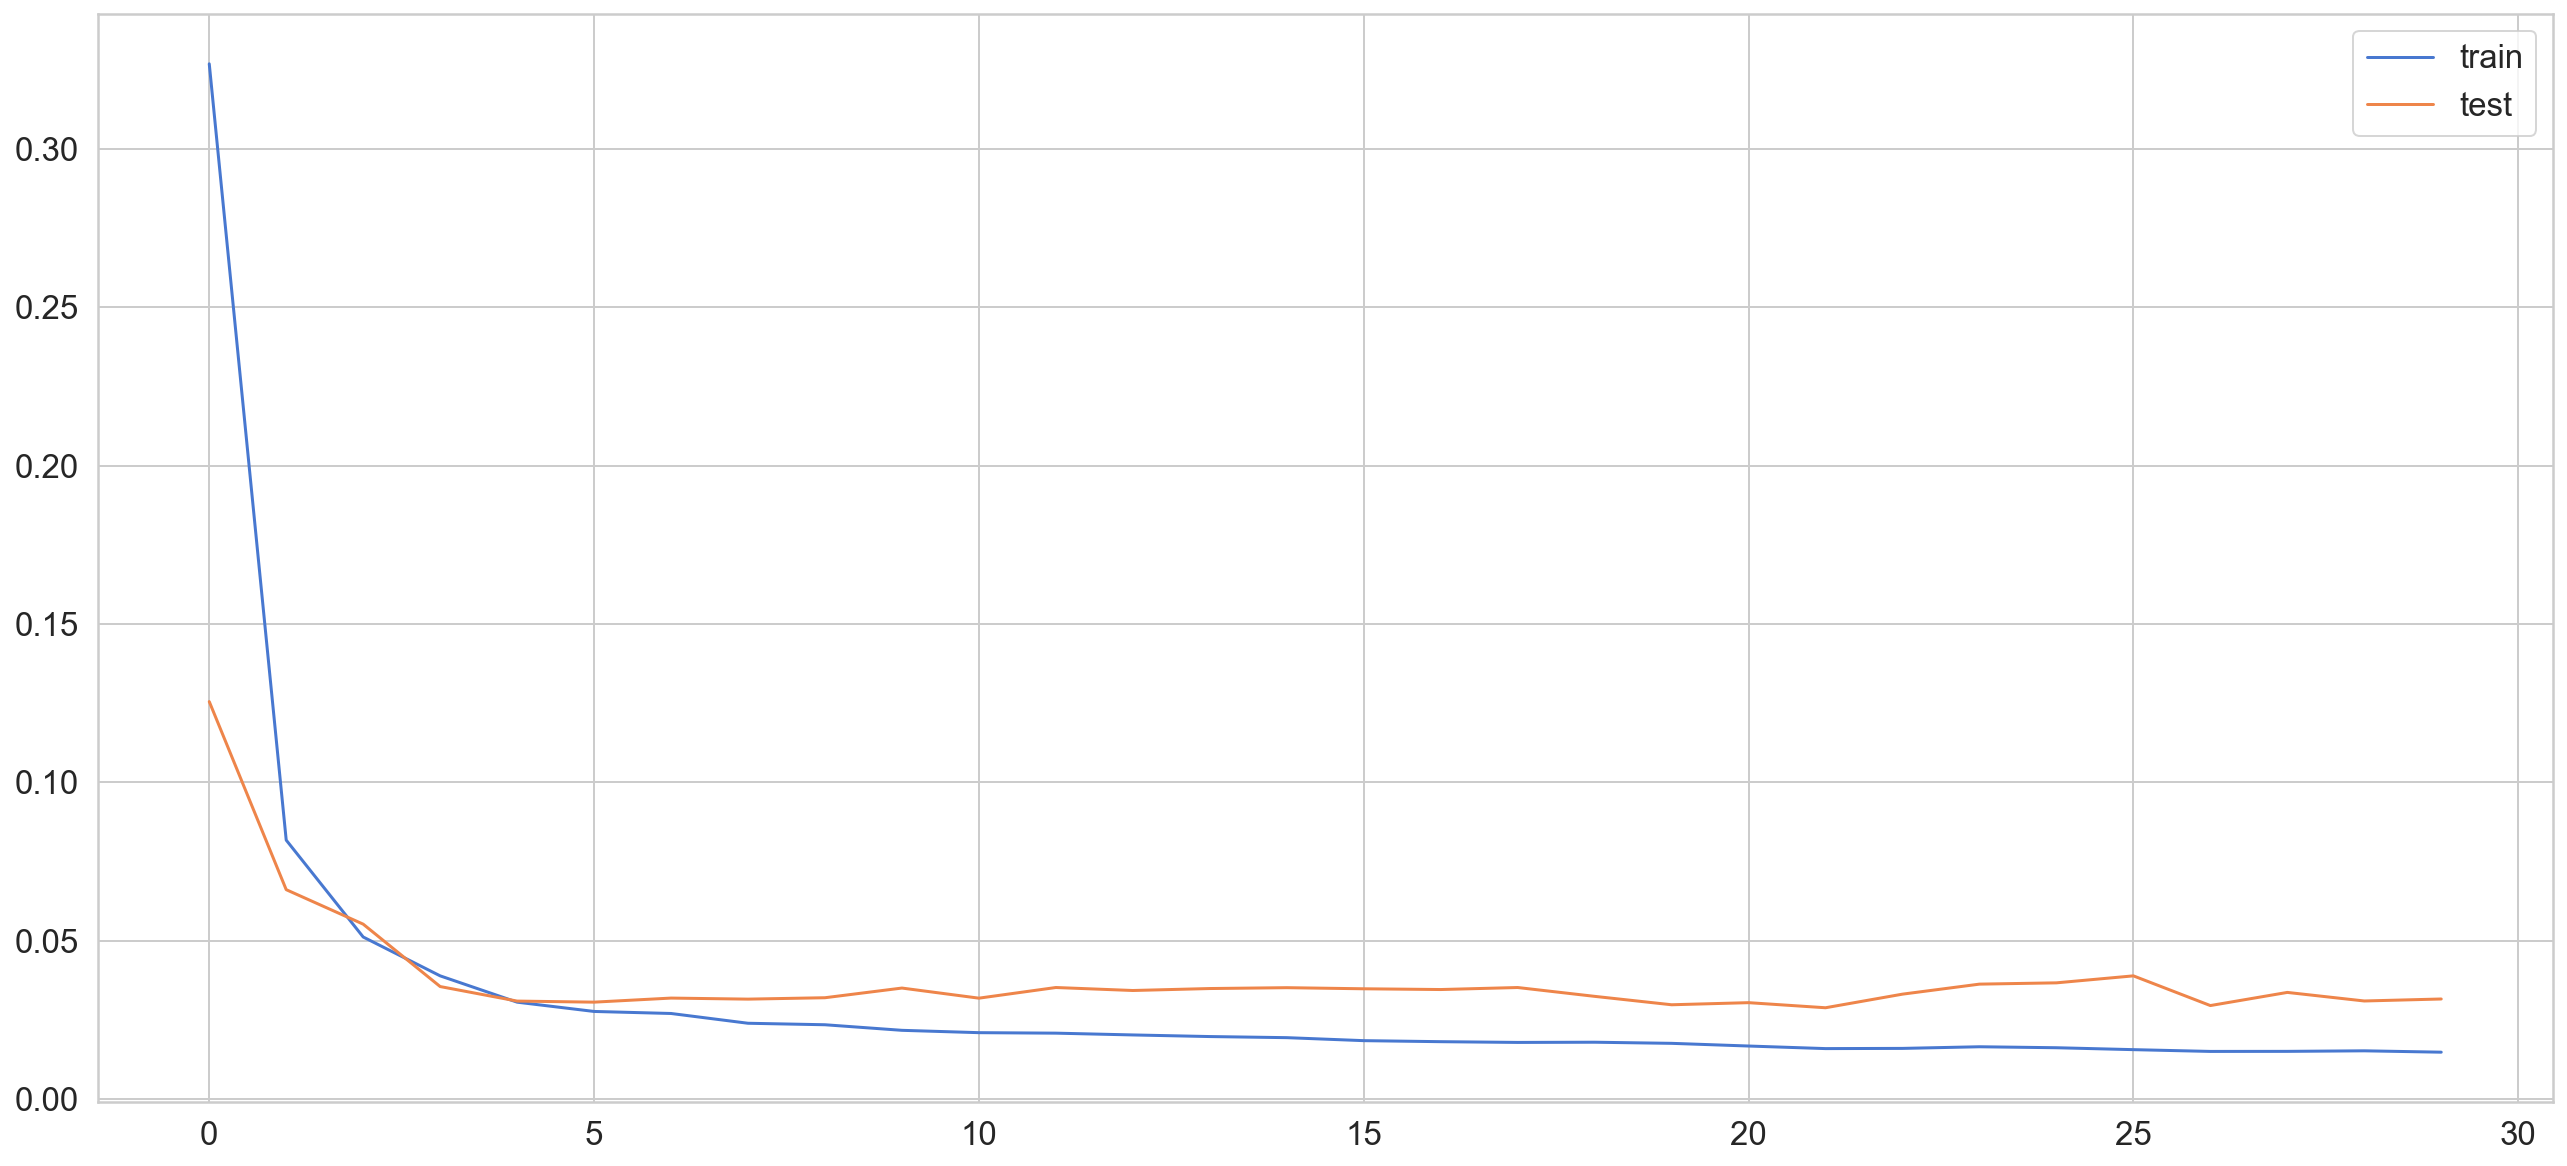

In [15]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [16]:
y_pred = model.predict(X_test)

In [17]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

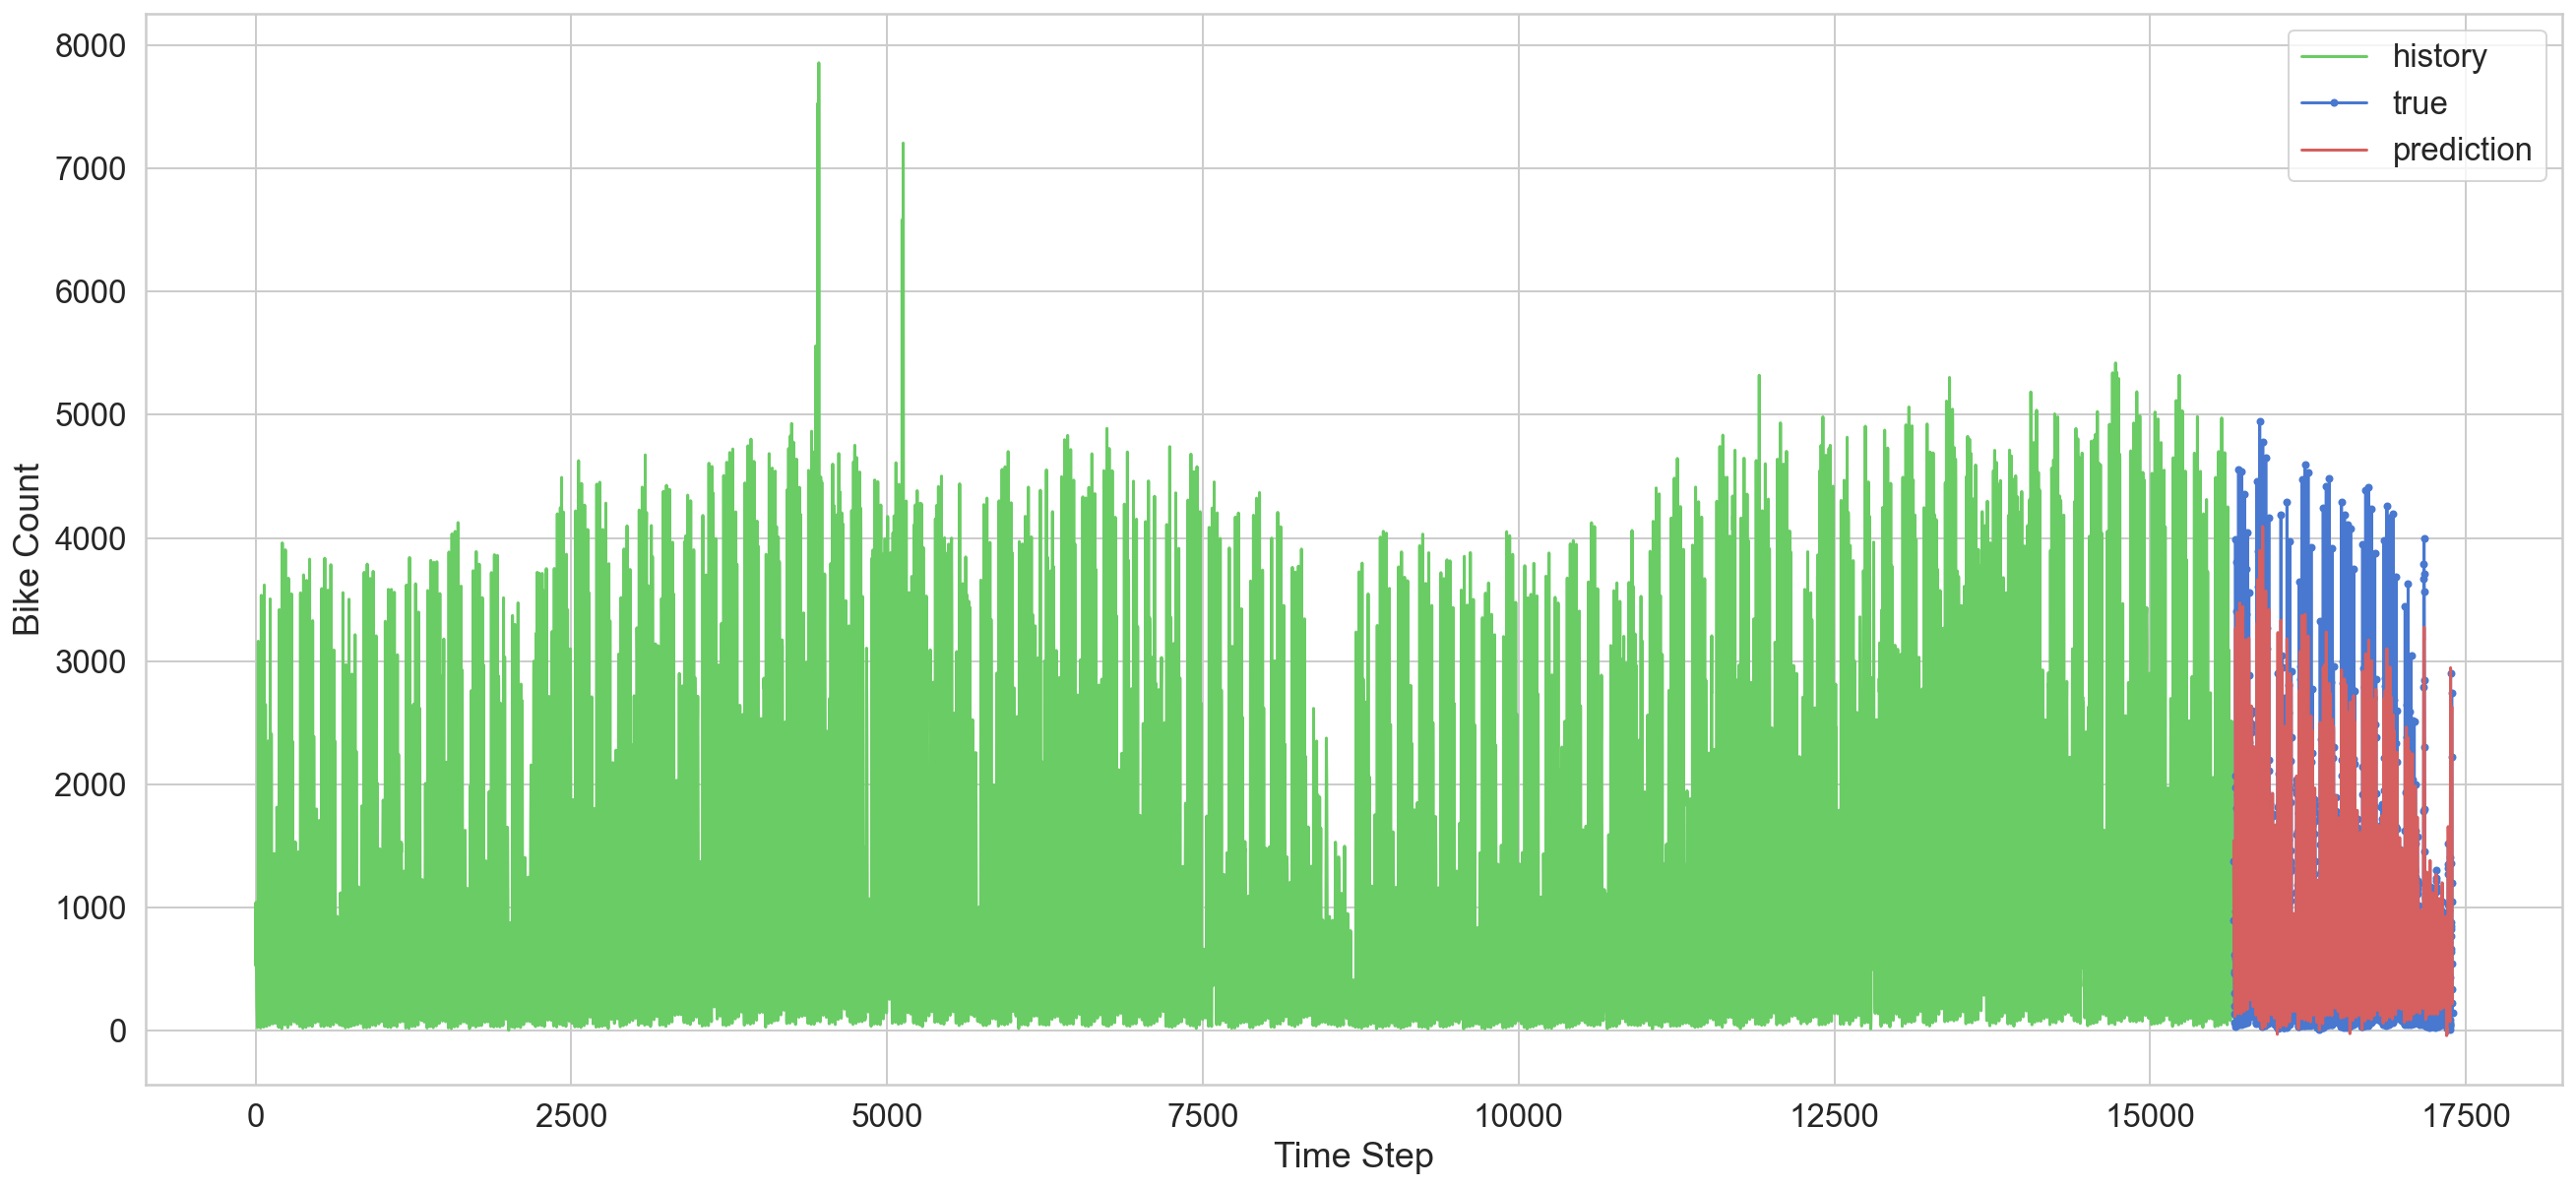

In [18]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

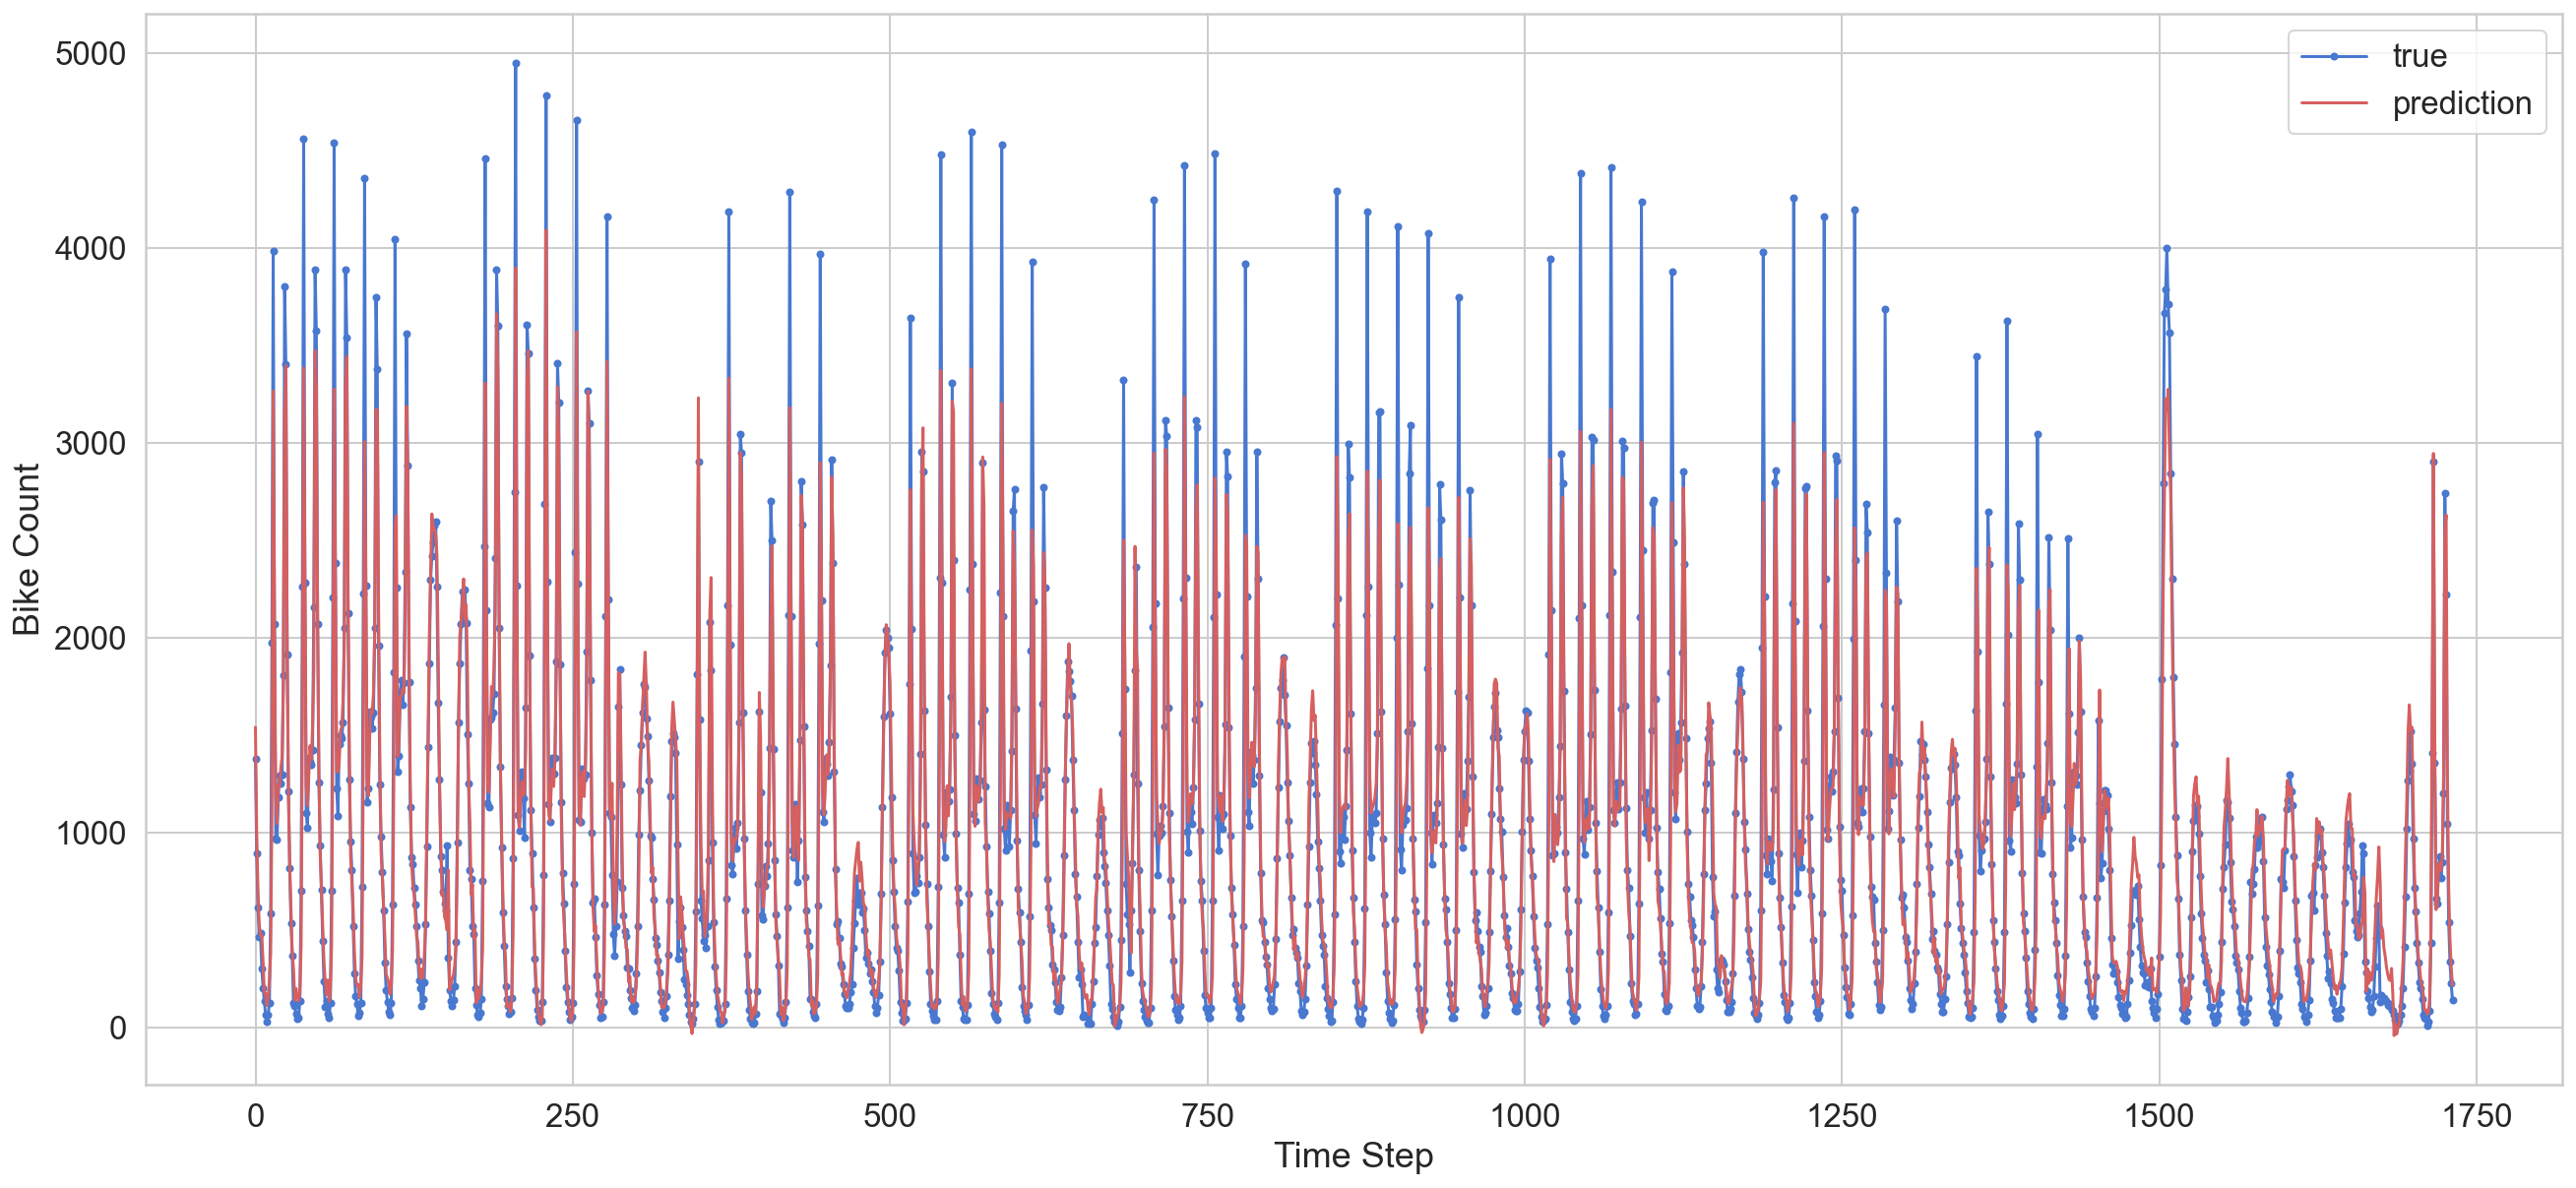

In [19]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

Here we predict the Number of bicycle   with LSTMs using TensorFlow 2 and Keras in Python.

Here i had  used Multivariate  Time Series data to predict future demand of bicycle

Bidirectional LSTM Neural Network is build to make the predictions.
